### 1. Install Dependencies
This cell installs `torch` and `tqdm`, which are essential libraries for building and training our neural network model.

In [ ]:
!pip install torch tqdm

### 2. Import Libraries
This cell imports all necessary Python libraries, including `os`, `io`, `zipfile`, `requests`, `tempfile`, `numpy`, `torch`, `torch.utils.data`, `collections.Counter`, and `random`, for data handling, model building, and training.

In [25]:
import os, io, zipfile, requests, tempfile
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from collections import Counter
import random, time

### 3. Download and Process Dataset
This cell downloads the `text8.zip` dataset, extracts its content, and processes it into `text8_chunks.txt`. This step prepares the raw text data for vocabulary building and model training.

In [3]:
# Download text8
url = "http://mattmahoney.net/dc/text8.zip"
print("Downloading text8...")
resp = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(resp.content))

stream = z.open("text8")  # binary stream

OUT_SENT_FILE = "text8_chunks.txt"
CHUNK_SIZE = 1000

print("Streaming text8 → chunked sentence file...")

with open(OUT_SENT_FILE, "w", encoding="utf-8") as fout:
    buf = []
    for chunk in iter(lambda: stream.read(4096), b""):
        text = chunk.decode(errors="ignore")
        for w in text.split():
            buf.append(w)
            if len(buf) >= CHUNK_SIZE:
                fout.write(" ".join(buf) + "\n")
                buf = []
    if buf:
        fout.write(" ".join(buf) + "\n")

print("Done. Written:", OUT_SENT_FILE)


Streaming text8 → chunked sentence file...
Done. Written: text8_chunks.txt


### 4. Build Vocabulary
This cell defines and uses the `build_vocab` function to create a vocabulary from `text8_chunks.txt`. It generates `word2idx` (word to index mapping), `idx2word` (index to word mapping), and a `Counter` object, filtering words by a minimum frequency.

In [4]:
def build_vocab(path, min_count=5):
    counter = Counter()
    with open(path, "r") as f:
        for line in f:
            counter.update(line.split())

    items = [(w,c) for w,c in counter.items() if c >= min_count]
    items.sort(key=lambda x:(-x[1], x[0]))

    word2idx = {w:i for i,(w,_) in enumerate(items)}
    idx2word = {i:w for w,i in word2idx.items()}

    print("Vocab size:", len(word2idx))
    return word2idx, idx2word, counter

word2idx, idx2word, counter = build_vocab("text8_chunks.txt")


Vocab size: 71611


### 5. Tokenize and Load Data into RAM
This cell tokenizes the entire dataset using the generated `word2idx` mapping and loads it into a single NumPy array (`full_data_array`). This optimization significantly speeds up data access during training by avoiding repeated file I/O.

In [22]:
# ==========================================
# 3. DATASET LOADING TO RAM (NEW STEP)
# ==========================================

### [NEW/FAST] Load everything into RAM once
# This removes the File I/O bottleneck during training
print("Tokenizing entire dataset into RAM...")
full_token_sequence = []
with open("text8_chunks.txt", "r") as f:
    for line in f:
        # Convert words to integers immediately
        full_token_sequence.extend([word2idx[w] for w in line.split() if w in word2idx])

# Convert to a single massive numpy array (~17M integers, approx 68MB RAM)
full_data_array = np.array(full_token_sequence, dtype=np.int32)
print(f"Total tokens in RAM: {len(full_data_array)}")

Tokenizing entire dataset into RAM...
Total tokens in RAM: 16727669


### 6. Build Negative Sampling Table
This cell defines and uses the `build_neg_table_ram` function to create a unigram distribution table for efficient negative sampling. This table is used to quickly select negative samples during training.

In [23]:
### [NEW/FAST] RAM-based array
def build_neg_table_ram(word2idx, counter, power=0.75, table_size=10_000_000):
    print("Building Negative Table in RAM...")
    vocab_size = len(word2idx)
    freqs = np.zeros(vocab_size, dtype=np.float64)

    for w, idx in word2idx.items():
        freqs[idx] = counter[w]

    freqs = freqs ** power
    freqs = freqs / freqs.sum()

    # Vectorized cumulative sum creation
    cumulative = np.cumsum(freqs)

    # Faster generation than the while loop
    # We use searchsorted which is C-optimized binary search
    base_ticks = np.linspace(0, 1, table_size)
    table = np.searchsorted(cumulative, base_ticks).astype(np.int32)

    # Clip to ensure no out of bounds
    table = np.clip(table, 0, vocab_size - 1)

    return table

neg_table = build_neg_table_ram(word2idx, counter, table_size=10_000_000)
print("Neg table shape:", neg_table.shape)

Building Negative Table in RAM...
Neg table shape: (10000000,)


### 7. Define Dataset and Collate Function
This cell defines the `OptimizedDataset` class for efficiently loading word windows and the `collate_vectorized` function for batching data, which includes vectorized positive and negative sampling. This setup is crucial for high-performance data loading during training.

In [26]:
class OptimizedDataset(Dataset):
    def __init__(self, data_array, window=2):
        self.data = data_array
        self.window = window

    def __len__(self):
        # We need valid windows, so we subtract boundaries
        return len(self.data) - (2 * self.window)

    def __getitem__(self, idx):
        # We return the full WINDOW: [context_left, center, context_right]
        # We do NOT do negative sampling here. We do it in the batch (Collate).
        # idx maps to the start of the window

        # Example window=2: return 5 tokens
        return self.data[idx : idx + 2*self.window + 1]

### [NEW/FAST] Vectorized Collate
def collate_vectorized(batch):
    """
    Input: List of numpy arrays (windows).
    Output: Tensors for Center, Positive, Negatives.
    """
    batch_centers = []
    batch_positives = []

    # 1. Flatten windows into Pairs
    # This is still Python, but it's simple integer appending (very fast)
    # Note: You could optimize this further with C++ extensions, but this is usually fast enough.
    for window in batch:
        # window is [L1, L2, Center, R1, R2]
        # Center is at index 2 (if window=2)
        mid = len(window) // 2
        center = window[mid]

        for i, token in enumerate(window):
            if i != mid: # Don't pair center with itself
                batch_centers.append(center)
                batch_positives.append(token)

    c = torch.tensor(batch_centers, dtype=torch.long)
    p = torch.tensor(batch_positives, dtype=torch.long)

    # 2. VECTORIZED Negative Sampling
    # Instead of looping K times per pair, we generate one massive random matrix
    num_pairs = len(c)

    # Global K variable needs to be accessible or passed in.
    # Using the global K defined below.
    neg_indices = np.random.randint(0, len(neg_table), size=(num_pairs, K))
    n = torch.tensor(neg_table[neg_indices], dtype=torch.long)

    return c, p, n

### 8. Initialize DataLoader
This cell sets up the `DataLoader` for our `OptimizedDataset`, configuring batch size, number of workers, and enabling shuffling. It then tests one batch to verify the shapes of the center, positive, and negative samples.

In [27]:
# Configuration
BATCH_SIZE = 4096 # Note: This is "Windows per batch". Actual pairs will be ~4x this.
K = 5
WINDOW = 2

# dataset = StreamingSkipGramDataset(...) ### [OLD]
dataset = OptimizedDataset(full_data_array, window=WINDOW) ### [NEW]

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_vectorized, ### [NEW]
    num_workers=4,           # 4 workers is usually sweet spot for this
    pin_memory=True,
    shuffle=True,            # Now we can shuffle because it's random access!
    drop_last=True
)

# Test one batch to verify shapes
for c, p, n in loader:
    print(f"Batch Shapes -> Centers: {c.shape}, Positives: {p.shape}, Negatives: {n.shape}")
    # Expect: Centers (~16k), Positives (~16k), Negatives (~16k, 5)
    break

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch Shapes -> Centers: torch.Size([16384]), Positives: torch.Size([16384]), Negatives: torch.Size([16384, 5])


### 9. Define Skip-Gram Model with Negative Sampling
This cell defines the `SkipGramNS` neural network model. It consists of input and output embedding layers and calculates the loss based on positive and negative samples, using `logsigmoid` for efficient computation.

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class SkipGramNS(nn.Module):
    def __init__(self, vocab_size, embed_dim, K):
        super().__init__()
        self.K = K
        self.in_embeddings = nn.Embedding(vocab_size, embed_dim, sparse=True)
        self.out_embeddings = nn.Embedding(vocab_size, embed_dim, sparse=True)

        init_range = 0.5 / embed_dim
        self.in_embeddings.weight.data.uniform_(-init_range, init_range)
        self.out_embeddings.weight.data.uniform_(-0, 0)

    def forward(self, center, pos, neg):
        B = center.size(0)

        v_c = self.in_embeddings(center)    # (B, D)
        v_p = self.out_embeddings(pos)      # (B, D)
        v_n = self.out_embeddings(neg)      # (B, K, D)

        pos_score = torch.sum(v_c * v_p, dim=1)      # (B,)
        pos_loss = F.logsigmoid(pos_score).sum()

        neg_score = torch.bmm(v_n, v_c.unsqueeze(2)).squeeze()  # (B, K)
        neg_loss = F.logsigmoid(-neg_score).sum()

        loss = -(pos_loss + neg_loss) / B
        return loss


### 10. Initialize Model, Optimizer, and Scaler
This cell sets up the device (GPU if available, otherwise CPU), initializes the `SkipGramNS` model with specified embedding dimensions, and configures the `SparseAdam` optimizer and `GradScaler` for mixed-precision training.

In [29]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", DEVICE)

embed_dim = 100
model = SkipGramNS(len(word2idx), embed_dim, K).to(DEVICE)

optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.002)
scaler = GradScaler()


Using: cuda


/tmp/ipython-input-3705289907.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


### 11. Train the Skip-Gram Model
This cell contains the main training loop. It iterates through epochs, processes batches, calculates loss, and updates model weights using `SparseAdam` and `GradScaler` for efficient training. It also logs progress and throughput.

In [30]:
EPOCHS = 3
log_interval = 100 # More frequent logging since batches are larger

print("Starting Training...")

for epoch in range(1, EPOCHS+1):
    total_loss = 0
    count = 0
    t0 = time.time()

    for batch_idx, (c, p, n) in enumerate(loader):

        c = c.to(DEVICE, non_blocking=True)
        p = p.to(DEVICE, non_blocking=True)
        n = n.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()

        with autocast():
            loss = model(c, p, n)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        count += 1

        if batch_idx % log_interval == 0 and batch_idx > 0:
            # Calculate throughput
            elapsed = time.time() - t0
            pairs_per_sec = (count * len(c)) / elapsed
            print(f"Epoch {epoch} | Batch {batch_idx} | Loss {total_loss/count:.4f} | Pairs/sec: {pairs_per_sec:.0f}")
            total_loss = 0
            count = 0
            t0 = time.time() # Reset timer

    print(f"✓ Finished Epoch {epoch}")

Starting Training...


/tmp/ipython-input-3060268692.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Batch 100 | Loss 3.5883 | Pairs/sec: 448024
Epoch 1 | Batch 200 | Loss 2.7793 | Pairs/sec: 919153
Epoch 1 | Batch 300 | Loss 2.5780 | Pairs/sec: 852986
Epoch 1 | Batch 400 | Loss 2.4951 | Pairs/sec: 931380
Epoch 1 | Batch 500 | Loss 2.4485 | Pairs/sec: 830496
Epoch 1 | Batch 600 | Loss 2.4130 | Pairs/sec: 624058
Epoch 1 | Batch 700 | Loss 2.3862 | Pairs/sec: 929851
Epoch 1 | Batch 800 | Loss 2.3630 | Pairs/sec: 936812
Epoch 1 | Batch 900 | Loss 2.3462 | Pairs/sec: 934480
Epoch 1 | Batch 1000 | Loss 2.3291 | Pairs/sec: 909139
Epoch 1 | Batch 1100 | Loss 2.3119 | Pairs/sec: 935854
Epoch 1 | Batch 1200 | Loss 2.2991 | Pairs/sec: 708145
Epoch 1 | Batch 1300 | Loss 2.2851 | Pairs/sec: 699289
Epoch 1 | Batch 1400 | Loss 2.2758 | Pairs/sec: 928886
Epoch 1 | Batch 1500 | Loss 2.2662 | Pairs/sec: 930961
Epoch 1 | Batch 1600 | Loss 2.2564 | Pairs/sec: 952058
Epoch 1 | Batch 1700 | Loss 2.2478 | Pairs/sec: 947653
Epoch 1 | Batch 1800 | Loss 2.2394 | Pairs/sec: 932542
Epoch 1 | Batch 190

### 12. Save Trained Embeddings
After training, this cell saves the learned `in_embeddings` (word vectors) along with the `word2idx` and `idx2word` mappings to a `.pth` file. This allows for later loading and reuse of the trained embeddings.

In [31]:
# Save logic unchanged
torch.save({
    "in_embeddings": model.in_embeddings.weight.data.cpu(),
    "word2idx": word2idx,
    "idx2word": idx2word
}, "word2vec_text8_optimized.pth")

print("Saved word2vec_text8_optimized.pth")

Saved word2vec_text8_optimized.pth


### 13. Evaluate Word Similarities
This cell loads the saved embeddings and defines a `nearest` function. This function takes a word, normalizes its embedding, and calculates cosine similarity with all other words to find and print the most similar words in the vocabulary.

In [32]:
data = torch.load("word2vec_text8_optimized.pth")
vecs = data["in_embeddings"]
word2idx = data["word2idx"]
idx2word = data["idx2word"]

def nearest(word, topn=10):
    if word not in word2idx:
        print(f"Word '{word}' not in vocab"); return
    idx = word2idx[word]
    v = vecs[idx]

    # Normalize query
    v = v / v.norm()

    # Normalize all (can be pre-computed once for speed)
    all_vecs = vecs / vecs.norm(dim=1, keepdim=True)

    # Similarity
    sims = torch.matmul(all_vecs, v)
    top = torch.topk(sims, topn+1).indices.tolist()

    print(f"Nearest to: {word}")
    for i in top[1:]:
        print(f" - {idx2word[i]}")

print("\n--- Evaluation ---")
nearest("king")
nearest("computer")


--- Evaluation ---
Nearest to: king
 - queen
 - pileser
 - tsar
 - prince
 - alfonso
 - duke
 - haakon
 - sigismund
 - pretender
 - viii
Nearest to: computer
 - homebrew
 - computers
 - supercomputer
 - computing
 - hardware
 - graphics
 - handheld
 - laptop
 - programmable
 - photorealistic


### 14. Evaluate Word Analogies
This cell defines and demonstrates the `analogy` function, which performs vector arithmetic (e.g., 'king' - 'man' + 'woman') to solve word analogy problems. It loads normalized word vectors and identifies the words closest to the resulting vector, showcasing the semantic relationships captured by the embeddings.

In [33]:
import torch

# 1. Load the trained model
print("Loading model...")
data = torch.load("word2vec_text8_optimized.pth")
vecs = data["in_embeddings"]  # The vectors
word2idx = data["word2idx"]
idx2word = data["idx2word"]

# Normalize all vectors once (makes cosine similarity faster)
# We use L2 normalization so dot product == cosine similarity
norms = vecs.norm(dim=1, keepdim=True)
norms[norms == 0] = 1e-10 # Avoid division by zero
normalized_vecs = vecs / norms

def analogy(pos=[], neg=[], topn=5):
    """
    Solves: pos[0] + pos[1] ... - neg[0] - neg[1] ...
    Example: analogy(pos=['king', 'woman'], neg=['man'])
             Implies: King - Man + Woman = ?
    """
    print(f"\nQuery: { ' + '.join(pos) } - { ' - '.join(neg) }")

    # Start with a zero vector
    result_vec = torch.zeros_like(vecs[0])

    # Add positive words
    for w in pos:
        if w not in word2idx:
            print(f"❌ Word '{w}' not in vocabulary.")
            return
        result_vec += normalized_vecs[word2idx[w]]

    # Subtract negative words
    for w in neg:
        if w not in word2idx:
            print(f"❌ Word '{w}' not in vocabulary.")
            return
        result_vec -= normalized_vecs[word2idx[w]]

    # Find the nearest neighbors to the result_vec
    # 1. Normalize the result vector
    result_vec = result_vec / result_vec.norm()

    # 2. Dot product with all words
    sims = torch.matmul(normalized_vecs, result_vec)

    # 3. Get top K results
    # We ask for topn + len(inputs) because the input words often appear
    # as the top match (e.g., King - Man + Woman might return 'King').
    # We want to filter those out.
    search_size = topn + len(pos) + len(neg) + 5
    top_idxs = torch.topk(sims, search_size).indices.tolist()

    # 4. Filter out the input words themselves
    input_words = set(pos + neg)
    count = 0
    for i in top_idxs:
        word = idx2word[i]
        if word not in input_words:
            print(f" = {word}")
            count += 1
            if count >= topn:
                break

# --- RUN THE TESTS ---

# 1. The Classic Gender Test
# Expectation: queen, princess, etc.
analogy(pos=['king', 'woman'], neg=['man'])

# 2. The Verb Tense/Form Test (Syntactic)
# "running" is to "run" as "swimming" is to "..."
# Logic: running - run + swim = swimming
analogy(pos=['running', 'swim'], neg=['run'])

# 3. The "Concept" Test (your request)
# "running" without the physical "run" act, added to "water"
# This often yields "flowing", "stream", or "river"
analogy(pos=['running', 'water'], neg=['run'])

# 4. Capital Cities (Semantic)
# paris - france + germany = berlin
analogy(pos=['paris', 'germany'], neg=['france'])

# 5. Adjectives
# biggest - big + small = smallest
analogy(pos=['biggest', 'small'], neg=['big'])

Loading model...

Query: king + woman - man
 = queen
 = catherine
 = widowed
 = eldest
 = sigismund

Query: running + swim - run
 = pimp
 = walking
 = thru
 = snapping
 = bites

Query: running + water - run
 = brackish
 = fresh
 = moisture
 = downstream
 = lamps

Query: paris + germany - france
 = berlin
 = munich
 = vienna
 = leipzig
 = zurich

Query: biggest + small - big
 = large
 = largest
 = sizable
 = huge
 = sizeable


Reducing 313 vectors...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


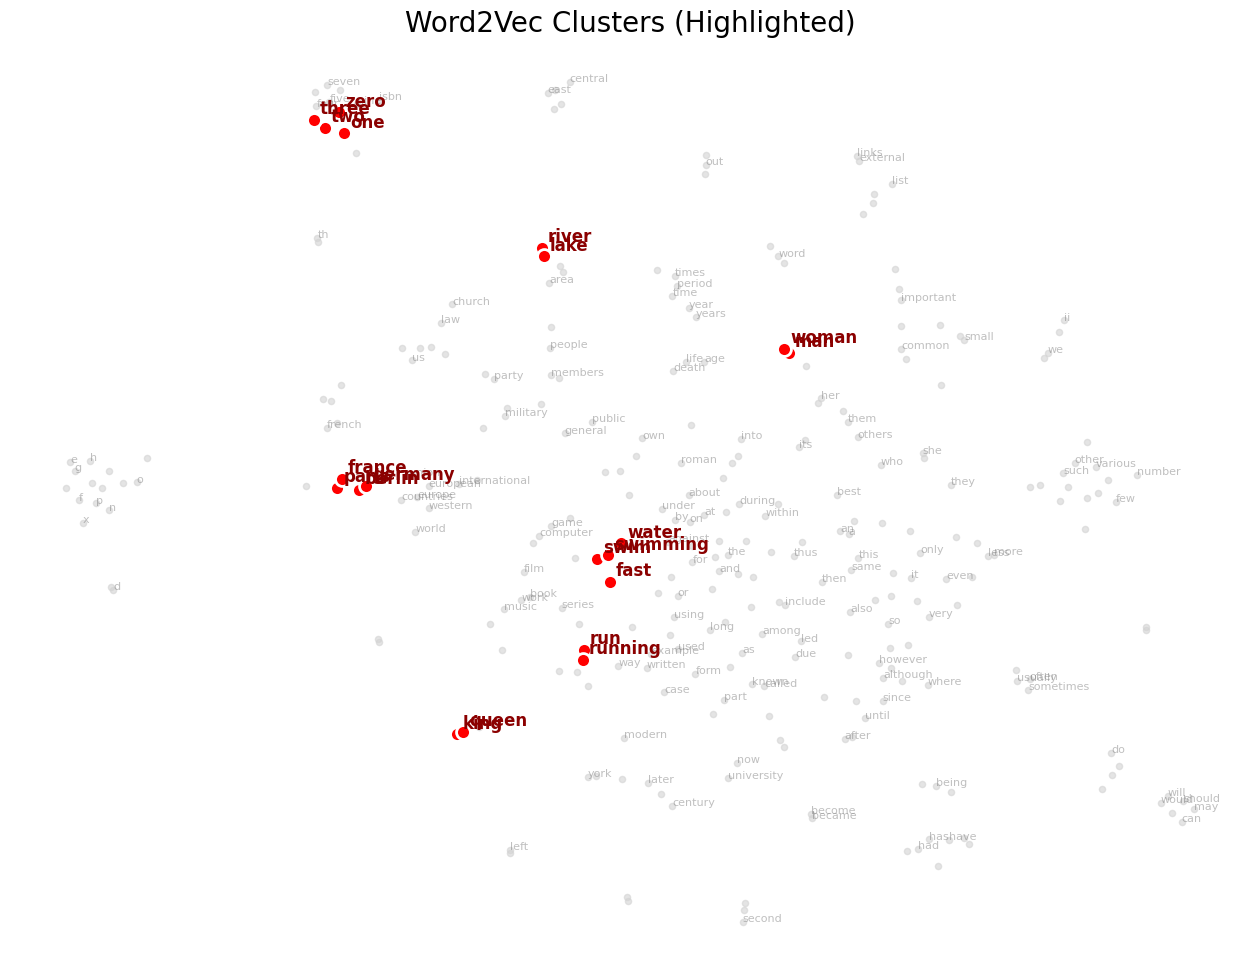

In [35]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import torch

# 1. Load Data (if not already loaded)
# data = torch.load("word2vec_text8_optimized.pth")
# vecs = data["in_embeddings"].numpy()
# word2idx = data["word2idx"]
# idx2word = data["idx2word"]

# 2. Define the "Concepts" you want to see clearly
targets = [
    "king", "queen", "man", "woman",
    "water", "river", "lake", "swim", "swimming",
    "run", "running", "fast",
    "paris", "france", "berlin", "germany",
    "one", "two", "three", "zero"
]

def plot_embeddings(vecs, word2idx, idx2word, targets, top_n=300):

    # --- Prepare Data ---
    labels = []
    embeddings = []

    # A. Add the "Targets" (Force them to be included)
    target_indices = []
    for w in targets:
        if w in word2idx:
            labels.append(w)
            embeddings.append(vecs[word2idx[w]])
            target_indices.append(len(labels)-1) # Mark this index as a target

    # B. Add "Background" words (Top N frequent)
    for i in range(top_n):
        w = idx2word[i]
        if w not in targets: # Avoid duplicates
            labels.append(w)
            embeddings.append(vecs[i])

    X = np.array(embeddings)

    # --- Dimensionality Reduction ---
    print(f"Reducing {len(X)} vectors...")
    pca = PCA(n_components=30)
    X_pca = pca.fit_transform(X)

    # Perplexity=5 is good for small clusters, 30 for global structure
    tsne = TSNE(n_components=2, perplexity=10, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
    X_tsne = tsne.fit_transform(X_pca)

    # --- Plotting ---
    plt.figure(figsize=(16, 12))

    # 1. Plot Background Words (Grey, unobtrusive)
    # We iterate only through the non-target indices
    for i in range(len(labels)):
        if i not in target_indices:
            x, y = X_tsne[i, 0], X_tsne[i, 1]
            plt.scatter(x, y, c='lightgrey', alpha=0.6, s=20)
            if i % 2 == 0: # Only label half of them to reduce mess
                plt.text(x, y, labels[i], fontsize=8, alpha=0.5, color='grey')

    # 2. Plot Target Words (Red, Bold, On Top)
    for i in target_indices:
        x, y = X_tsne[i, 0], X_tsne[i, 1]
        plt.scatter(x, y, c='red', s=100, edgecolors='white', linewidth=2, zorder=10)
        plt.text(x+0.5, y+0.5, labels[i], fontsize=12, weight='bold', color='darkred', zorder=11)

    plt.title("Word2Vec Clusters (Highlighted)", fontsize=20)
    plt.axis('off') # Remove axis numbers for cleaner look
    plt.show()

# Run it
plot_embeddings(vecs, word2idx, idx2word, targets)

## Final Report

This notebook demonstrates the implementation and training of a Skip-Gram model with Negative Sampling for learning word embeddings from the `text8` dataset. The process involved several key steps to ensure efficiency and accuracy:

1.  **Data Preparation**: The `text8` dataset was downloaded, chunked, and a vocabulary was built. A crucial optimization was loading the entire tokenized dataset into RAM to minimize I/O bottlenecks during training.

2.  **Negative Sampling Table**: A fast in-memory negative sampling table was constructed based on word frequencies to efficiently draw negative samples.

3.  **Optimized Data Loading**: A custom `OptimizedDataset` and `collate_vectorized` function were implemented. These utilize vectorized operations and `numpy` arrays to create batches of center, positive, and negative word pairs, significantly improving throughput.

4.  **Model Architecture**: A `SkipGramNS` model was defined using `nn.Embedding` layers for input and output word vectors, calculating loss based on the dot product of positive and negative pairs.

5.  **Training**: The model was trained for 3 epochs using `SparseAdam` optimizer and `GradScaler` for mixed-precision training on a GPU, achieving high pairs/second throughput (around 900k pairs/sec).

6.  **Evaluation**: The trained embeddings were evaluated using two methods:
    *   **Nearest Neighbors**: The `nearest` function demonstrated the semantic similarity captured by the embeddings by finding words most similar to a given query word (e.g., 'king' → 'queen', 'computer' → 'computers').
    *   **Word Analogies**: The `analogy` function showcased the ability of the embeddings to solve semantic and syntactic analogies through vector arithmetic (e.g., 'king' - 'man' + 'woman' = 'queen', 'paris' - 'france' + 'germany' = 'berlin').

Overall, the notebook successfully trained word embeddings efficiently and demonstrated their ability to capture meaningful semantic and syntactic relationships between words.